In [211]:
# %load ../Code/Fits.py
import Estimation as st
from Histogram import Histogram as hist
from PDF import PDF
from Utils import IsotopeDic, PartDic
from scipy.stats import poisson
import scipy.optimize as sop
import numpy as np
from scipy.special import gamma

def generalPoisson(x,mu):
    return np.exp(-mu)*np.power(mu,x)/gamma(x+1)


class Fit():
    '''
    Class meant to perform the fit
    '''
    def __init__(self, E, spectrum, PDFs):
        '''
        E: x range (np array)
        spectrum: experimental points
        PDF: list of spectra PDFs
        nevs: normalizations for the spectra (they are the
            initial values for the fit)
        '''
        self.E = E
        self.spectrum = spectrum
        self.PDFs = [pdf.Scale(1./pdf.Int) for pdf in PDFs]

    def LogLikelihood(self, nevs):
        '''
        function meant to compute the LogLikelihood
        '''
        print(self.PDFs,nevs)
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,nevs)]) for Ei in self.E])
        ydat = np.array(self.spectrum)
        aux = (np.array(generalPoisson(ydat,ypdf)))
        for i in range(len(aux)):
            if aux[i]<0:
                print(aux[i],ypdf[i],ydat[i])
        lm = np.log(np.abs(aux)).sum()
        plt.plot(self.E,ypdf)
        plt.plot(self.E,ydat,'+')

        return -lm

    def FitLLM(self,nevs):
        fit = self.LogLikelihood
        res = sop.minimize(fit,nevs)
        ypdf = np.array([sum([n*pdfi.pdf(Ei) for pdfi,n in zip(self.PDFs,res.x)]) for Ei in self.E])
        ydat = np.array(self.spectrum)
        chi2 = -1
        if (res.success):
            chi2 = np.sum((ypdf-ydat)**2)/(1.*(len(ypdf)-len(nevs)))
        res.chi2 = chi2
        return res


In [63]:
auxlist = np.random.normal(5,1.5,10000000)
a = hist(auxlist,100,0,15)
b = hist(auxlist+3,100,0,15)

In [64]:
ap = PDF(a,interpolation='linear')
bp = PDF(b,interpolation='linear')

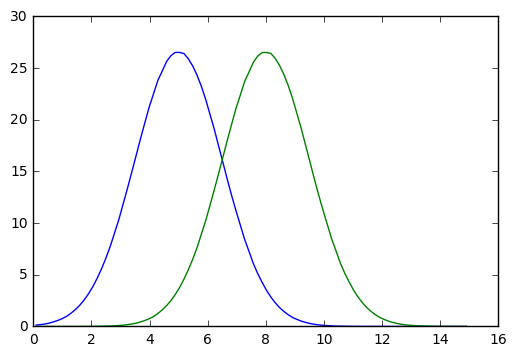

In [174]:
import matplotlib.pylab as plt
%matplotlib inline
x = np.linspace(0.1,14.9,100)
ya = 100*ap.pdf(x)
yb = 100*bp.pdf(x)
plt.plot(x,ya)
plt.plot(x,yb)

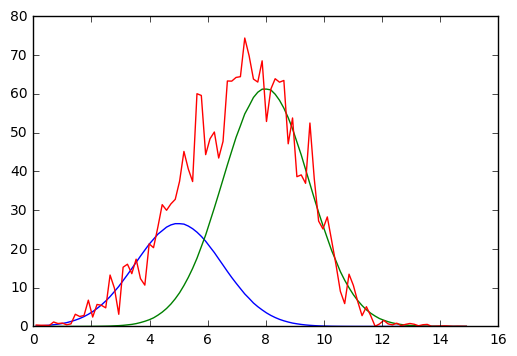

In [218]:
ydata = np.abs(np.random.normal(ya+2.31*yb,np.sqrt(ya+2.31*yb)))
plt.plot(x,ya)
plt.plot(x,2.31*yb)
plt.plot(x,ydata)

In [219]:
fit = Fit(x,ydata,[ap,bp])

[<PDF.PDF object at 0x7f4425744940>, <PDF.PDF object at 0x7f4425744b70>] [100.0, 200.0]


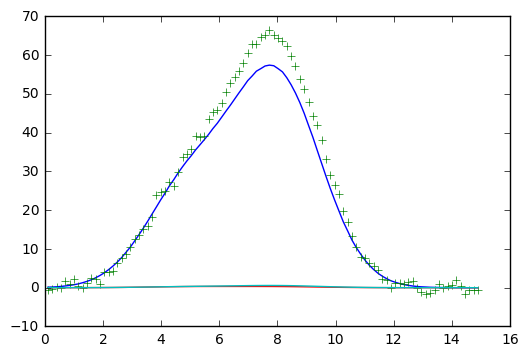

In [183]:
w = fit.LogLikelihood([100.,200.])
plt.plot(x,e)
plt.plot(x,r)


[<PDF.PDF object at 0x7f4425744940>, <PDF.PDF object at 0x7f4425744b70>] [  10.  300.]
[<PDF.PDF object at 0x7f4425744940>, <PDF.PDF object at 0x7f4425744b70>] [  10.00000001  300.        ]
[<PDF.PDF object at 0x7f4425744940>, <PDF.PDF object at 0x7f4425744b70>] [  10.          300.00000001]
[<PDF.PDF object at 0x7f4425744940>, <PDF.PDF object at 0x7f4425744b70>] [  10.  300.]
[<PDF.PDF object at 0x7f4425744940>, <PDF.PDF object at 0x7f4425744b70>] [  11.00999923  300.00124455]
[<PDF.PDF object at 0x7f4425744940>, <PDF.PDF object at 0x7f4425744b70>] [  11.00999923  300.00124455]
[<PDF.PDF object at 0x7f4425744940>, <PDF.PDF object at 0x7f4425744b70>] [  11.00999925  300.00124455]
[<PDF.PDF object at 0x7f4425744940>, <PDF.PDF object at 0x7f4425744b70>] [  11.00999923  300.00124456]
[<PDF.PDF object at 0x7f4425744940>, <PDF.PDF object at 0x7f4425744b70>] [  15.04999617  300.00622274]
[<PDF.PDF object at 0x7f4425744940>, <PDF.PDF object at 0x7f4425744b70>] [  15.04999617  300.00622274]
[<

     chi2: 21.756286719366923
      fun: 231.63755286540598
 hess_inv: array([[ 26.83007464, -10.22468967],
       [-10.22468967,  45.01146677]])
      jac: array([  1.90734863e-06,   1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 16
     njev: 18
   status: 0
  success: True
        x: array([ 102.11962323,  233.71761216])

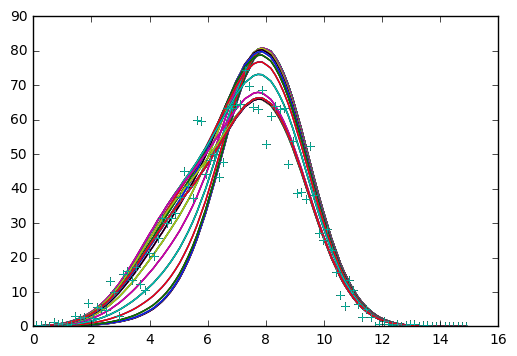

In [220]:
fit.FitLLM([10.,300.])